In [122]:
%run "part01_preprocessing.ipynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
 8   Unnamed: 8   0 non-null       float64
dtypes: float64(3), int64(1), object(5)
memory usage: 37.2+ MB


In [123]:
HTML("""
<style>

h1 {
    background-color: DarkSlateGray;
    color: white;
    padding: 15px 15px;
    text-align: center;
    font-family: Arial, Helvetica, sans-serif;
    border-radius:10px 10px;
}

h2 {
    background-color: CadetBlue;
    color: white;
    padding: 10px 10px;
    text-align: center;
    font-family: Arial, Helvetica, sans-serif
    border-radius:10px 10px;
}

h3 {
    background-color: LightSeaGreen;
    color: white;
    padding: 10px 10px;
    text-align: center;
    font-family: Arial, Helvetica, sans-serif
    border-radius:10px 10px;
}


</style>
""")

# Statatistical Quartile Model

In [124]:
from IPython.display import HTML
from matplotlib import pyplot as plt
import seaborn as sns
import dataframe_image as di
%matplotlib inline

In [125]:
rfm = data_client_resume.copy()

In [126]:
r_labels = range(5, 0, -1)
f_labels = range(1, 6, 1)
m_labels = range(1, 10, 1)

rfm["R"] = pd.qcut(rfm["RecencyDays"], 5, labels = r_labels)
rfm["F"] = pd.qcut(rfm["Frequency"].rank(method = 'first'), 5, labels = f_labels)
rfm["M"] = pd.qcut(rfm["GrossRevenueTotal"], 9, labels = m_labels)

rfm.sample(10)

,GrossRevenueTotal,RecencyDays,Frequency,R,F,M
CustomerID,,,,,,
15717,150.30,235.0,1.0,1,1,1
14646,279489.02,2.0,73.0,5,5,9
16463,1383.70,22.0,4.0,4,4,7
14099,3092.97,17.0,11.0,4,5,8
17591,2215.02,74.0,7.0,2,5,8
16240,3693.81,25.0,2.0,4,3,9
12509,176.50,285.0,1.0,1,1,2
17781,188.02,160.0,2.0,2,3,2
16825,775.18,39.0,2.0,3,3,5


In [127]:
rfm["RFM"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)
rfm["Score"] = rfm[["R", "F", "M"]].sum(axis = 1)

In [128]:
segt_map = {
    r'[1-2][1-2][1-9]': 'Hinernating',
    r'[1-2][3-4][1-9]': 'At Risk',
    r'[1-2]5[1-9]': 'Cannot Lose Them',
    r'3[1-2][1-9]': 'About to Sleep',
    r'33[1-9]': 'Need Attention',
    r'[3-4][4-5][1-9]': 'Loyal Customers',
    r'41[1-9]': 'Promising',
    r'51[1-9]': 'New Customers',
    r'[4-5][2-3][1-9]': 'Potential Loyalists',
    r'5[4-5][1-9]': 'Champions'
}

rfm['Segment'] = rfm['RFM'].replace(segt_map, regex=True)
#rfm['RFM'] = rfm['R'].astype(str) + rfm['F'].astype(str) 
rfm.head()

,GrossRevenueTotal,RecencyDays,Frequency,R,F,M,RFM,Score,Segment
CustomerID,,,,,,,,,
17850,5288.63,373.0,34.0,1,5,9,159,15,Cannot Lose Them
13047,3079.10,32.0,10.0,4,5,8,458,17,Loyal Customers
12583,7187.34,3.0,15.0,5,5,9,559,19,Champions
13748,948.25,96.0,5.0,2,4,6,246,12,At Risk
15100,635.10,334.0,3.0,1,3,5,135,9,At Risk


In [129]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot Lose Them": [4, 5, 0, 0.4],
                   "At Risk": [2, 4, 0, 0.4],
                   "Hinernating": [0, 2, 0, 0.4],
                   "About to Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

In [130]:
report = rfm[['GrossRevenueTotal','RecencyDays','Frequency','RFM','Segment']].groupby('Segment').agg( MonetarySum = ('GrossRevenueTotal', 'sum'),
                                             MonetaryMean = ('GrossRevenueTotal', 'mean'),
                                             Recency = ('RecencyDays', 'mean'),
                                             Frequency = ('Frequency', 'mean'),
                                             Count = ('GrossRevenueTotal', 'count')).reset_index()

report['Percentage'] = round((report['Count'] / report['Count'].sum()*100),2)
report.set_index('Segment',inplace=True)
report = report.sort_values("MonetaryMean", ascending = False)

In [131]:
cm = sns.light_palette("#A2A2A2", as_cmap = True)

report=report.style.background_gradient(cmap = cm, axis = 0)\
    .set_precision(2)\
    .highlight_min(axis = 0, color = "#FF6347")\
    .highlight_max(axis = 0, color = "#2F4F4F")

report

,MonetarySum,MonetaryMean,Recency,Frequency,Count,Percentage
Segment,,,,,,
Champions,4258098.45,6491.00,6.41,12.08,656,15.20
Cannot Lose Them,167050.49,2880.18,129.71,8.59,58,1.34
Loyal Customers,2235515.73,2709.72,33.50,6.45,825,19.11
At Risk,575343.73,1044.18,140.21,2.98,551,12.77
Need Attention,163245.57,832.89,52.23,2.32,196,4.54
Potential Loyalists,340969.27,583.85,17.95,1.73,584,13.53
About to Sleep,143313.75,424.01,53.43,1.14,338,7.83
Promising,1164.90,388.30,20.33,1.00,3,0.07
Hinernating,428888.96,388.13,221.74,1.14,1105,25.60


In [132]:
di.export(report,'../images/rfm_statistic_table.png')

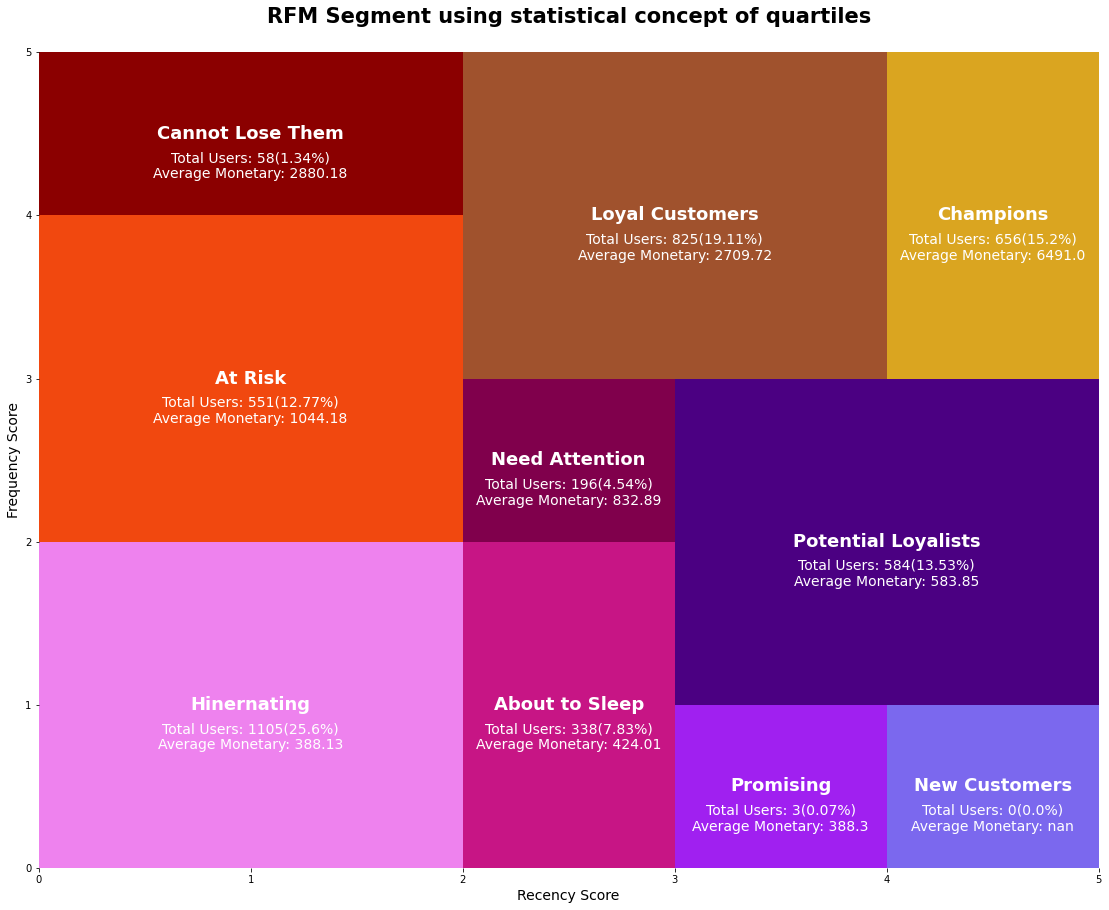

In [133]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"

palette = ["#DAA520", "#A0522D", "#8B0000", "#F1480F",  "#EE82EE", 
           "#C71585", "#A020F0", "#7B68EE", "#4B0082", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm[rfm.Segment == key].shape[0]
    users_percentage = (rfm[rfm.Segment == key].shape[0] / rfm.shape[0]) * 100
    avg_monetary = rfm[rfm.Segment == key]["GrossRevenueTotal"].mean()
    
    user_txt = "\n\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score", fontsize=14)
    ax.set_ylabel("Frequency Score", fontsize=14)
    
sns.despine(left = True, bottom = True)

plt.title('RFM Segment using statistical concept of quartiles\n', fontsize='21', fontweight='bold')
plt.savefig("..//images//rfm_statistic.png")
plt.show()